## Premier League Matchup Prediction

### Multiclass Classification Using Artificial Neural Network (ANN) Model

#### Roberto Ruiz, B.S. Petroleum Engineering & Certificate in CS, The University of Texas at Austin

This workflow demonstrates multiclass classification of Premier League data gathered from <a href="http://football-data.co.uk/englandm.php">this</a> website and previously prepared in the DataPreperation workflow. An artificial neural network is used to classify matchup results as "H" (home team win), "A" (away team win), or "D" (draw).

Feature selection is not done in this workflow as we attempt to use the most amount of data available for this particular ANN model.

### Artificial Neural Network Background

Artificial neural networks are powerful (nonlinear) machine learning methods inspired by nature that can be used for regression or classification. Additionally, artificial neural networks are considered universal function approximators (can learn any possible function over an interval). This workflow will use supervised learning and a multiclass classification artificial neural network.

**Input Layer**<br>
The input layer has input nodes for each predictor feature. Predictor features must be min/max normalized to remove any influence from scale differences. All predictor features' values should be in an interval from [-1,1] or [0,1]. This is done to not lose sensitivity when nonlinearly transforming inputs in nodes. We will use the [0,1] interval in this workflow.

**Hidden Layers**<br>
There can be multiple layers of nodes between the input layer and the output layer however, this workflow will contain a single hidden layer. The amount of nodes used for the hidden layer (width of the ANN) is a hyperparameter that will require tuning.

**Output Layer**<br>
The output layer will contain a node for each response feature. In this workflow, there will be three nodes (one for each class). The output function used will be the softmax activation function, giving probabilities for each class. The class with the highest probability will be the chosen response from the predictor features.

**Connections**<br>
The connections in ANN's are outputs from nodes in a layer inputted to nodes in another layer. Fully connected ANN's have every node in a layer connected to every node in the next layer. Feed-forward ANN's move information in a forward direction.

**Nodes**<br>
Nodes take a linearly weighted combination of inputs from previous layers of nodes, add a bias term, and nonlinearly transform the weighted combination. Nonlinear transformations at each node are called activation functions.

**Activation Functions**<br>
For this workflow the hidden layer will use a ReLU activation function and the output layer will use a Softmax activation function.

- ReLU Activation Function
$$f(x) = max(0,x)$$

- Softmax Activation Function
$$\frac{e^T_k}{\sum_{i=1}^K e^T_i}$$

**Forward & Backward Pass**<br>
In the forward pass the loss function is calculated and in the backward pass (backward propagation) the gradient of the loss with respect to each of the weights is calculated.

**Batches and Epochs**<br>
An epoch is considered one pass through all of the training data, while a batch is a certain number of samples considered for each forward and backward pass through the ANN.

**Learning Rate**<br>
The learning rate scales the change (calculated gradients from backward propagation) to the individual weights in the network.

***Note***<br>
Information and code for this workflow has been both inspired and adapted from <a href="https://github.com/GeostatsGuy">GeostatsGuy</a> and <a href="https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab">Akshaj Verma</a>

### The Workflow
Pytorch will be used to create, train, and test our ANN. We will need some standard packages for this workflow.

In [1]:
import pandas as pd               # Pandas data analysis and data frame tool
import numpy as np                # Numpy scientific computing tool
import matplotlib.pyplot as plt   # Matplotlib for visualizing data
import seaborn as sns             # Seaborn for statistical data visualization
%matplotlib inline

import torch                      # Pytorch open source machine learning framework for ANN
import torch.nn.functional as F
from tqdm import tqdm             # Smart progress meter used in tarining and validation of ANN
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split  # Train, testing split function to split train and test data
from sklearn.metrics import confusion_matrix, classification_report  # confusion matrix and classification report for result summary

#### Observe Data Framework
Have a quick glimpse at the features and data in the loaded framework. Keys to the abbreviations of the features are listed below.<br>
- FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
- unixtime = Date in unixtime of when the match happened
- HFUD = Home team Fatigue Unixtime Difference (unixtime difference between team's last game and current game)
- AFUD = Away team Fatigue Unixtime Difference (unixtime difference between team's last game and current game)
- HGDPH = Home team Goal Difference Playing Home (goals in favor - goals against -- while playing home before current matchup)
- AGDPH = Away team Goal Difference Playing Home (goals in favor - goals against -- while playing home before current matchup)
- HGDPA = Home team Goal Difference Playing Away (goals in favor - goals against -- while playing away before current matchup)
- AGDPA = Away team Goal Difference Playing Away (goals in favor - goals against -- while playing away before current matchup)
- HTGD = Home team Total Goal Difference (goals in favor - goals against before current matchup)
- ATGD = Away team Total Goal Difference (goals in favor - goals against before current matchup)
- HCP = Home team Current Points (points gained before current matchup)
- ACP = Away team Current Points (points gained before current matchup)
- HGP = Home team Games Played (games played before current matchup)
- AGP = Away team Games Played (games played before current matchup)
- HSOV = Home team Strength of Victory (how strong were the teams victories before current matchup)
- ASOV = Away team Strength of Victory (how strong were the teams victories before current matchup)
- HHGD = Home team Halftime Goal Difference (halftime goals in favor - halftime goals against -- before current matchup)
- AHGD = Away team Halftime Goal Difference (halftime goals in favor - halftime goals against -- before current matchup)
- HSPG = Home team Shots Per Game (shots per game before current matchup)
- ASPG = Away team Shots Per Game (shots per game before current matchup)
- HTSPG = Home team on Target Shots Per Game (on target shots per game before current matchup)
- ATSPG = Away team on Target Shots Per Game (on target shots per game before current matchup)
- HFPG = Home team Fouls Per Game (fouls per game before current matchup)
- AFPG = Away team Fouls Per Game (fouls per game before current matchup)
- HCPG = Home team Corners Per Game (corners per game before current matchup)
- ACPG = Away team Corners Per Game (corners per game before current matchup
- HYPG = Home team Yellows Per Game (yellow cards per game before current matchup)
- AYPG = Away team Yellows Per Game (yellow cards per game before current matchup)
- HRPG = Home team Reds Per Game (red cards per game before current matchup)
- ARPG = Away team Reds Per Game (red cards per game before current matchup)

In [2]:
full_df = pd.read_csv('PL_all_seasons.csv')
full_df.head(5)

,HomeTeam,AwayTeam,FTR,unixtime,HFUD,AFUD,HGDPH,AGDPH,HGDPA,AGDPA,...,HTSPG,ATSPG,HFPG,AFPG,HCPG,ACPG,HYPG,AYPG,HRPG,ARPG
0,Arsenal,Everton,H,1060992000,1209600.0,1209600.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Birmingham,Tottenham,H,1060992000,1209600.0,1209600.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Blackburn,Wolves,H,1060992000,1209600.0,1209600.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Fulham,Middlesbrough,H,1060992000,1209600.0,1209600.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Leicester,Southampton,D,1060992000,1209600.0,1209600.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Observe Summary Statistics
Check for any missing data or irregular data.

In [3]:
full_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unixtime,6577.0,1.330508e+09,1.579230e+08,1.060992e+09,1.194739e+09,1.329005e+09,1.463270e+09,1.607818e+09
HFUD,6577.0,6.651237e+05,4.424553e+05,1.728000e+05,5.184000e+05,6.048000e+05,6.912000e+05,9.158400e+06
AFUD,6577.0,6.686574e+05,4.453174e+05,1.728000e+05,5.184000e+05,6.048000e+05,6.912000e+05,9.244800e+06
HGDPH,6577.0,3.210430e+00,8.552016e+00,-2.700000e+01,-2.000000e+00,1.000000e+00,6.000000e+00,4.800000e+01
AGDPH,6577.0,3.388475e+00,8.873558e+00,-2.700000e+01,-2.000000e+00,1.000000e+00,7.000000e+00,4.700000e+01
HGDPA,6577.0,-3.296792e+00,8.739233e+00,-3.800000e+01,-8.000000e+00,-2.000000e+00,1.000000e+00,3.100000e+01
AGDPA,6577.0,-3.117227e+00,8.424874e+00,-3.600000e+01,-8.000000e+00,-2.000000e+00,1.000000e+00,3.100000e+01
HTGD,6577.0,-8.636156e-02,1.525004e+01,-6.500000e+01,-9.000000e+00,-1.000000e+00,6.000000e+00,7.600000e+01
ATGD,6577.0,2.712483e-01,1.523877e+01,-6.300000e+01,-8.000000e+00,-1.000000e+00,6.000000e+00,7.800000e+01
HCP,6577.0,2.496321e+01,1.826593e+01,0.000000e+00,1.000000e+01,2.200000e+01,3.600000e+01,9.400000e+01


#### Plot Bargraph of Final Time Results Count

c:\users\roberto ruiz\.conda\envs\plpenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='FTR', ylabel='count'>

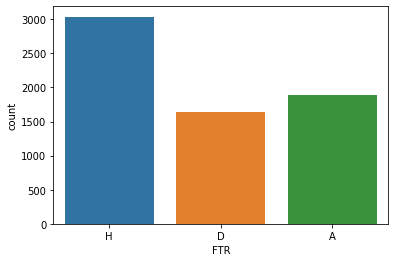

In [4]:
sns.countplot(full_df['FTR'])

#### Calculate Percentage of Home team wins, Away team wins, and Draws

In [5]:
full_df['FTR'].value_counts()/len(full_df)

H    0.461761
A    0.288125
D    0.250114
Name: FTR, dtype: float64

#### Replace Categorical Values
Let's replace categorical values "A", "D", and "H" from the FTR column with 0, 1, and 2, respectively. This is done because our ANN will need numerical values for classification.

In [6]:
full_df['FTR'].replace({'A':0, 'D':1, 'H':2}, inplace=True)
full_df.head(5)

,HomeTeam,AwayTeam,FTR,unixtime,HFUD,AFUD,HGDPH,AGDPH,HGDPA,AGDPA,...,HTSPG,ATSPG,HFPG,AFPG,HCPG,ACPG,HYPG,AYPG,HRPG,ARPG
0,Arsenal,Everton,2,1060992000,1209600.0,1209600.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Birmingham,Tottenham,2,1060992000,1209600.0,1209600.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Blackburn,Wolves,2,1060992000,1209600.0,1209600.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Fulham,Middlesbrough,2,1060992000,1209600.0,1209600.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Leicester,Southampton,1,1060992000,1209600.0,1209600.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
class2indx = {0:'A',1:'D',2:'H'}

#### Seperate Predictor Features and Labels

In [8]:
df_X = full_df.drop(columns=['HomeTeam','AwayTeam','FTR'])
s_y = full_df['FTR']
s_y

0       2
1       2
2       2
3       2
4       1
       ..
6572    2
6573    1
6574    1
6575    0
6576    2
Name: FTR, Length: 6577, dtype: int64

#### Normalize Predictor Features
We need to normalize input features between the interval [0,1].

In [9]:
df_X = df_X.apply(lambda column: (column - min(column))/(max(column)-min(column)), axis=0)
df_X

,unixtime,HFUD,AFUD,HGDPH,AGDPH,HGDPA,AGDPA,HTGD,ATGD,HCP,...,HTSPG,ATSPG,HFPG,AFPG,HCPG,ACPG,HYPG,AYPG,HRPG,ARPG
0,0.0,0.115385,0.114286,0.360000,0.364865,0.550725,0.537313,0.460993,0.446809,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.115385,0.114286,0.360000,0.364865,0.550725,0.537313,0.460993,0.446809,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.115385,0.114286,0.360000,0.364865,0.550725,0.537313,0.460993,0.446809,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.115385,0.114286,0.360000,0.364865,0.550725,0.537313,0.460993,0.446809,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.115385,0.114286,0.360000,0.364865,0.550725,0.537313,0.460993,0.446809,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6572,1.0,0.038462,0.047619,0.386667,0.283784,0.579710,0.432836,0.489362,0.354610,0.212766,...,0.350649,0.153110,0.478114,0.437710,0.279720,0.282828,0.290909,0.272727,0.000000,0.045455
6573,1.0,0.048077,0.047619,0.373333,0.418919,0.550725,0.686567,0.468085,0.546099,0.170213,...,0.272727,0.258373,0.417508,0.478114,0.398601,0.227273,0.290909,0.236364,0.045455,0.000000
6574,1.0,0.057692,0.047619,0.280000,0.527027,0.492754,0.492537,0.390071,0.510638,0.074468,...,0.279221,0.334928,0.468013,0.377104,0.286713,0.333333,0.400000,0.163636,0.045455,0.000000
6575,1.0,0.048077,0.057143,0.320000,0.310811,0.536232,0.402985,0.432624,0.354610,0.138298,...,0.220779,0.142105,0.377104,0.377778,0.391608,0.244444,0.290909,0.260000,0.045455,0.000000


#### Split Data Into Training, Validation, and Testing Sets
We first split our data into train/validation (combined) set and test set. Then take the train/validation set and split it into a train set and validation set. <br><br>
Set stratify to the corresponding labels to balance the unbalanced data set.

In [10]:
# Split train/validation and testing sets
X_val_train, X_test, y_val_train, y_test = train_test_split(df_X, s_y, test_size = 0.2, stratify=s_y, random_state = 21)

# Split train and validation
X_train, X_val, y_train, y_val = train_test_split(X_val_train, y_val_train, test_size = 0.2, stratify=y_val_train, random_state = 69)

#### Check if Distributions are Similar for All Sets

In [11]:
y_train.value_counts()/len(y_train)

2    0.461740
0    0.288023
1    0.250238
Name: FTR, dtype: float64

In [12]:
y_val.value_counts()/len(y_val)

2    0.461538
0    0.288699
1    0.249763
Name: FTR, dtype: float64

In [13]:
y_test.value_counts()/len(y_test)

2    0.462006
0    0.287994
1    0.250000
Name: FTR, dtype: float64

#### Create a Dataset Class
Inherit from pytroch's Dataset class and define initialization, getitem, and length functions.

In [14]:
class PLDataset(Dataset):
    
    def __init__(self, X_features, y_labels):
        self.X_features = X_features
        self.y_labels = y_labels
        
    def __getitem__(self, index):
        return self.X_features[index], self.y_labels[index]
    
    def __len__(self):
        return len(self.X_features)

#### Make Datasets into Object Datasets
Turn the training, validation, and testing datasets into PLDataset objects. Turn predictor features and labels from numpy arrays to torch tensors.

In [15]:
train_set = PLDataset(torch.from_numpy(X_train.values).float(), torch.from_numpy(y_train.values).long())
val_set = PLDataset(torch.from_numpy(X_val.values).float(), torch.from_numpy(y_val.values).long())
test_set = PLDataset(torch.from_numpy(X_test.values).float(), torch.from_numpy(y_test.values).long())

#### Class Balancing in Batches
Although training, validation, and test datasets were stratified, each batch will no necessarily be balanced. Let's attempt to balance the classes in each batch of training our ANN sees, so it can be better trained for each case.
<br><br>
Obtain all labels from the training set in a list and convert to a tensor. We can now count the amount of times each class appears in our training labels, make weights of each class from these counts (meant to over-represent under-represented classes), and apply the weights to the labels tensor.

In [16]:
targets = [y for x,y in train_set] 
targets = torch.tensor(targets)
class_count = [i for i in y_train.value_counts()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
weight_per_sample = class_weights[targets]

#### Create a Weighted Random Sampler Object
Use the weight_per_sample as the weights parameter. This is done to balance the classes. Set replacement to true (sampling with replacement).

In [17]:
sample_weights = WeightedRandomSampler(weights=weight_per_sample, num_samples=len(weight_per_sample), replacement=True)

#### Set Important Variables
Choose epochs, batch size, and learning rate. Multiple epochs, batch sizes, and learning rates were tested and these seemed to give the best result.

In [18]:
EPOCHS = 300
BATCH_SIZE = 8
LEARNING_RATE = 0.0007
NUM_FEATURES = len(df_X.columns)
NUM_CLASSES = 3

#### Declare DataLoader Objects for Training, Validation, and Testing

In [19]:
train_DL = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, sampler=sample_weights)
val_DL = DataLoader(dataset=val_set)
test_DL = DataLoader(dataset=test_set)

#### Create Artificial Neural Network
Now we need to create a fully connected artificial neural network. This ANN will contain an input layer, a hidden layer with a ReLU activation function, and an output layer with a softmax activation function.

In [20]:
class PLNN(nn.Module):
    
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.fc1 = nn.Linear(n_features,16)
        self.fc2 = nn.Linear(16, n_classes)
        
        self.relu = nn.ReLU()
        self.batchn1 = nn.BatchNorm1d(16)
        
    def forward(self, x):
        x = self.relu(self.batchn1(self.fc1(x)))
        x = self.fc2(x)
        
        return x
        

In [21]:
# let's set our device (cuda if available --> cpu if not )
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Declare PLNN (Premier League Neural Network) Object
Make an instance of the PLNN object and make it run on gpu or cpu. The criterion is going to be the loss function that will be used for this ANN. Refer to the <a href="https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html">documentation</a> for more information. For our optimizer we will use Adam (Adaptive Moment Estimation) optimization. Adam is a variant of stochastic gradient descent. Print the model to observe the structure.

In [22]:
model = PLNN(NUM_FEATURES, NUM_CLASSES)
model.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model

PLNN(
  (fc1): Linear(in_features=29, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
  (batchn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

#### Function to Calculate Accuracy Per Epoch

In [23]:
def acc_epoch(y_resp, y_correct):
    
    y_resp_softmax = torch.log_softmax(y_resp, dim = 1)
    values, y_resp_idxs = torch.max(y_resp_softmax, dim = 1)   
    correct = (y_resp_idxs == y_correct).float()
    acc = correct.sum() / len(correct)
    
    return torch.round(acc) * 100

In [24]:
acc_dict = {'train': [], "val": [] }
loss_dict = {'train': [], "val": [] }

#### Train Model and Use Model With Validation Set
The code below is from an <a href="https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab">article</a> written by Akshaj Verma. This code trains the ANN and tests the ANN on the validation set after each epoch. It also prints and formats accuracy and loss at each epoch nicely.

In [25]:
for e in tqdm(range(1, EPOCHS+1)):
    
    # Train model
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_DL:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = acc_epoch(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # Test model with validation set    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_DL:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = acc_epoch(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    
    loss_dict['train'].append(train_epoch_loss/len(train_DL))
    loss_dict['val'].append(val_epoch_loss/len(val_DL))
    acc_dict['train'].append(train_epoch_acc/len(train_DL))
    acc_dict['val'].append(val_epoch_acc/len(val_DL))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_DL):.5f} | Val Loss: {val_epoch_loss/len(val_DL):.5f} | Train Acc: {train_epoch_acc/len(train_DL):.3f}| Val Acc: {val_epoch_acc/len(val_DL):.3f}')

  0%|▎                                                                                 | 1/300 [00:03<15:32,  3.12s/it]

Epoch 001: | Train Loss: 0.63667 | Val Loss: 0.49023 | Train Acc: 78.327| Val Acc: 86.325


  1%|▌                                                                                 | 2/300 [00:05<13:50,  2.79s/it]

Epoch 002: | Train Loss: 0.35797 | Val Loss: 0.27992 | Train Acc: 96.578| Val Acc: 91.453


  1%|▊                                                                                 | 3/300 [00:06<12:20,  2.49s/it]

Epoch 003: | Train Loss: 0.30676 | Val Loss: 0.23723 | Train Acc: 98.289| Val Acc: 92.023


  1%|█                                                                                 | 4/300 [00:08<11:12,  2.27s/it]

Epoch 004: | Train Loss: 0.27374 | Val Loss: 0.23190 | Train Acc: 98.479| Val Acc: 92.023


  2%|█▎                                                                                | 5/300 [00:10<10:22,  2.11s/it]

Epoch 005: | Train Loss: 0.26641 | Val Loss: 0.24601 | Train Acc: 98.859| Val Acc: 91.928


  2%|█▋                                                                                | 6/300 [00:12<09:45,  1.99s/it]

Epoch 006: | Train Loss: 0.25533 | Val Loss: 0.22103 | Train Acc: 98.859| Val Acc: 92.498


  2%|█▉                                                                                | 7/300 [00:13<09:20,  1.91s/it]

Epoch 007: | Train Loss: 0.24023 | Val Loss: 0.21692 | Train Acc: 98.669| Val Acc: 91.833


  3%|██▏                                                                               | 8/300 [00:15<09:01,  1.86s/it]

Epoch 008: | Train Loss: 0.25280 | Val Loss: 0.19885 | Train Acc: 98.479| Val Acc: 92.498


  3%|██▍                                                                               | 9/300 [00:17<08:48,  1.81s/it]

Epoch 009: | Train Loss: 0.23598 | Val Loss: 0.19168 | Train Acc: 99.049| Val Acc: 92.023


  3%|██▋                                                                              | 10/300 [00:19<08:38,  1.79s/it]

Epoch 010: | Train Loss: 0.23168 | Val Loss: 0.20295 | Train Acc: 98.479| Val Acc: 92.403


  4%|██▉                                                                              | 11/300 [00:20<08:31,  1.77s/it]

Epoch 011: | Train Loss: 0.21515 | Val Loss: 0.20150 | Train Acc: 98.669| Val Acc: 92.023


  4%|███▏                                                                             | 12/300 [00:22<08:32,  1.78s/it]

Epoch 012: | Train Loss: 0.21896 | Val Loss: 0.19371 | Train Acc: 99.430| Val Acc: 91.738


  4%|███▌                                                                             | 13/300 [00:24<08:34,  1.79s/it]

Epoch 013: | Train Loss: 0.21912 | Val Loss: 0.18722 | Train Acc: 98.669| Val Acc: 92.498


  5%|███▊                                                                             | 14/300 [00:26<08:48,  1.85s/it]

Epoch 014: | Train Loss: 0.22289 | Val Loss: 0.19368 | Train Acc: 98.669| Val Acc: 92.972


  5%|████                                                                             | 15/300 [00:28<08:37,  1.82s/it]

Epoch 015: | Train Loss: 0.21568 | Val Loss: 0.19942 | Train Acc: 99.240| Val Acc: 92.213


  5%|████▎                                                                            | 16/300 [00:29<08:31,  1.80s/it]

Epoch 016: | Train Loss: 0.20555 | Val Loss: 0.18713 | Train Acc: 99.430| Val Acc: 92.688


  6%|████▌                                                                            | 17/300 [00:31<08:25,  1.78s/it]

Epoch 017: | Train Loss: 0.22480 | Val Loss: 0.19093 | Train Acc: 98.859| Val Acc: 92.403


  6%|████▊                                                                            | 18/300 [00:33<08:22,  1.78s/it]

Epoch 018: | Train Loss: 0.20880 | Val Loss: 0.18759 | Train Acc: 99.049| Val Acc: 92.498


  6%|█████▏                                                                           | 19/300 [00:35<08:19,  1.78s/it]

Epoch 019: | Train Loss: 0.20920 | Val Loss: 0.17897 | Train Acc: 99.430| Val Acc: 92.688


  7%|█████▍                                                                           | 20/300 [00:37<08:27,  1.81s/it]

Epoch 020: | Train Loss: 0.21687 | Val Loss: 0.17831 | Train Acc: 98.859| Val Acc: 92.498


  7%|█████▋                                                                           | 21/300 [00:38<08:22,  1.80s/it]

Epoch 021: | Train Loss: 0.21446 | Val Loss: 0.19180 | Train Acc: 98.859| Val Acc: 92.688


  7%|█████▉                                                                           | 22/300 [00:40<08:21,  1.80s/it]

Epoch 022: | Train Loss: 0.20554 | Val Loss: 0.18452 | Train Acc: 99.240| Val Acc: 92.498


  8%|██████▏                                                                          | 23/300 [00:42<08:11,  1.78s/it]

Epoch 023: | Train Loss: 0.19766 | Val Loss: 0.18234 | Train Acc: 99.049| Val Acc: 92.593


  8%|██████▍                                                                          | 24/300 [00:44<08:07,  1.77s/it]

Epoch 024: | Train Loss: 0.20587 | Val Loss: 0.19374 | Train Acc: 99.240| Val Acc: 92.118


  8%|██████▊                                                                          | 25/300 [00:45<08:03,  1.76s/it]

Epoch 025: | Train Loss: 0.20612 | Val Loss: 0.18604 | Train Acc: 98.859| Val Acc: 92.403


  9%|███████                                                                          | 26/300 [00:47<08:00,  1.76s/it]

Epoch 026: | Train Loss: 0.21120 | Val Loss: 0.18374 | Train Acc: 99.240| Val Acc: 92.118


  9%|███████▎                                                                         | 27/300 [00:49<07:59,  1.76s/it]

Epoch 027: | Train Loss: 0.22808 | Val Loss: 0.17807 | Train Acc: 98.859| Val Acc: 92.118


  9%|███████▌                                                                         | 28/300 [00:51<08:02,  1.77s/it]

Epoch 028: | Train Loss: 0.18801 | Val Loss: 0.19195 | Train Acc: 99.620| Val Acc: 92.403


 10%|███████▊                                                                         | 29/300 [00:53<08:09,  1.81s/it]

Epoch 029: | Train Loss: 0.20231 | Val Loss: 0.18493 | Train Acc: 98.479| Val Acc: 92.403


 10%|████████                                                                         | 30/300 [00:54<08:06,  1.80s/it]

Epoch 030: | Train Loss: 0.19919 | Val Loss: 0.19988 | Train Acc: 99.430| Val Acc: 92.308


 10%|████████▎                                                                        | 31/300 [00:56<07:59,  1.78s/it]

Epoch 031: | Train Loss: 0.19904 | Val Loss: 0.17427 | Train Acc: 99.430| Val Acc: 92.877


 11%|████████▋                                                                        | 32/300 [00:58<07:53,  1.77s/it]

Epoch 032: | Train Loss: 0.20021 | Val Loss: 0.19759 | Train Acc: 98.859| Val Acc: 91.548


 11%|████████▉                                                                        | 33/300 [01:00<07:56,  1.78s/it]

Epoch 033: | Train Loss: 0.19419 | Val Loss: 0.18408 | Train Acc: 99.430| Val Acc: 92.593


 11%|█████████▏                                                                       | 34/300 [01:01<07:52,  1.78s/it]

Epoch 034: | Train Loss: 0.20156 | Val Loss: 0.18477 | Train Acc: 99.430| Val Acc: 92.308


 12%|█████████▍                                                                       | 35/300 [01:03<07:47,  1.76s/it]

Epoch 035: | Train Loss: 0.20336 | Val Loss: 0.18843 | Train Acc: 99.430| Val Acc: 92.403


 12%|█████████▋                                                                       | 36/300 [01:05<07:45,  1.76s/it]

Epoch 036: | Train Loss: 0.19567 | Val Loss: 0.17973 | Train Acc: 99.240| Val Acc: 92.972


 12%|█████████▉                                                                       | 37/300 [01:07<07:44,  1.77s/it]

Epoch 037: | Train Loss: 0.20548 | Val Loss: 0.19701 | Train Acc: 99.049| Val Acc: 91.738


 13%|██████████▎                                                                      | 38/300 [01:08<07:42,  1.77s/it]

Epoch 038: | Train Loss: 0.19551 | Val Loss: 0.19215 | Train Acc: 99.240| Val Acc: 91.833


 13%|██████████▌                                                                      | 39/300 [01:10<07:38,  1.76s/it]

Epoch 039: | Train Loss: 0.20109 | Val Loss: 0.19034 | Train Acc: 98.479| Val Acc: 92.593


 13%|██████████▊                                                                      | 40/300 [01:12<07:36,  1.76s/it]

Epoch 040: | Train Loss: 0.20626 | Val Loss: 0.17283 | Train Acc: 98.859| Val Acc: 92.688


 14%|███████████                                                                      | 41/300 [01:14<07:36,  1.76s/it]

Epoch 041: | Train Loss: 0.19683 | Val Loss: 0.18275 | Train Acc: 99.430| Val Acc: 92.783


 14%|███████████▎                                                                     | 42/300 [01:15<07:34,  1.76s/it]

Epoch 042: | Train Loss: 0.18455 | Val Loss: 0.17341 | Train Acc: 99.810| Val Acc: 92.783


 14%|███████████▌                                                                     | 43/300 [01:17<07:30,  1.75s/it]

Epoch 043: | Train Loss: 0.18618 | Val Loss: 0.17498 | Train Acc: 99.430| Val Acc: 93.067


 15%|███████████▉                                                                     | 44/300 [01:19<07:27,  1.75s/it]

Epoch 044: | Train Loss: 0.20028 | Val Loss: 0.17747 | Train Acc: 99.430| Val Acc: 92.783


 15%|████████████▏                                                                    | 45/300 [01:21<07:24,  1.74s/it]

Epoch 045: | Train Loss: 0.17931 | Val Loss: 0.17293 | Train Acc: 99.620| Val Acc: 93.162


 15%|████████████▍                                                                    | 46/300 [01:22<07:23,  1.75s/it]

Epoch 046: | Train Loss: 0.19469 | Val Loss: 0.17119 | Train Acc: 99.620| Val Acc: 93.067


 16%|████████████▋                                                                    | 47/300 [01:24<07:25,  1.76s/it]

Epoch 047: | Train Loss: 0.18837 | Val Loss: 0.18904 | Train Acc: 99.430| Val Acc: 92.972


 16%|████████████▉                                                                    | 48/300 [01:26<07:23,  1.76s/it]

Epoch 048: | Train Loss: 0.19255 | Val Loss: 0.16991 | Train Acc: 99.430| Val Acc: 93.067


 16%|█████████████▏                                                                   | 49/300 [01:28<07:20,  1.75s/it]

Epoch 049: | Train Loss: 0.20007 | Val Loss: 0.18158 | Train Acc: 99.810| Val Acc: 92.972


 17%|█████████████▌                                                                   | 50/300 [01:29<07:17,  1.75s/it]

Epoch 050: | Train Loss: 0.19905 | Val Loss: 0.17532 | Train Acc: 99.620| Val Acc: 92.972


 17%|█████████████▊                                                                   | 51/300 [01:31<07:14,  1.75s/it]

Epoch 051: | Train Loss: 0.19052 | Val Loss: 0.17941 | Train Acc: 99.240| Val Acc: 93.067


 17%|██████████████                                                                   | 52/300 [01:33<07:12,  1.74s/it]

Epoch 052: | Train Loss: 0.19937 | Val Loss: 0.17176 | Train Acc: 99.810| Val Acc: 92.877


 18%|██████████████▎                                                                  | 53/300 [01:35<07:10,  1.74s/it]

Epoch 053: | Train Loss: 0.19620 | Val Loss: 0.17562 | Train Acc: 99.810| Val Acc: 92.498


 18%|██████████████▌                                                                  | 54/300 [01:36<07:09,  1.75s/it]

Epoch 054: | Train Loss: 0.20932 | Val Loss: 0.19026 | Train Acc: 98.859| Val Acc: 92.783


 18%|██████████████▊                                                                  | 55/300 [01:38<07:06,  1.74s/it]

Epoch 055: | Train Loss: 0.20058 | Val Loss: 0.17359 | Train Acc: 98.669| Val Acc: 93.257


 19%|███████████████                                                                  | 56/300 [01:40<07:04,  1.74s/it]

Epoch 056: | Train Loss: 0.19568 | Val Loss: 0.17766 | Train Acc: 99.049| Val Acc: 92.593


 19%|███████████████▍                                                                 | 57/300 [01:42<07:03,  1.74s/it]

Epoch 057: | Train Loss: 0.19999 | Val Loss: 0.17395 | Train Acc: 99.620| Val Acc: 92.688


 19%|███████████████▋                                                                 | 58/300 [01:43<07:04,  1.75s/it]

Epoch 058: | Train Loss: 0.18055 | Val Loss: 0.18488 | Train Acc: 99.620| Val Acc: 93.067


 20%|███████████████▉                                                                 | 59/300 [01:45<07:02,  1.75s/it]

Epoch 059: | Train Loss: 0.18560 | Val Loss: 0.17752 | Train Acc: 99.430| Val Acc: 92.783


 20%|████████████████▏                                                                | 60/300 [01:47<06:59,  1.75s/it]

Epoch 060: | Train Loss: 0.18839 | Val Loss: 0.17015 | Train Acc: 99.430| Val Acc: 92.877


 20%|████████████████▍                                                                | 61/300 [01:49<06:57,  1.75s/it]

Epoch 061: | Train Loss: 0.17780 | Val Loss: 0.17458 | Train Acc: 99.240| Val Acc: 93.352


 21%|████████████████▋                                                                | 62/300 [01:50<06:56,  1.75s/it]

Epoch 062: | Train Loss: 0.18833 | Val Loss: 0.18146 | Train Acc: 99.049| Val Acc: 93.257


 21%|█████████████████                                                                | 63/300 [01:52<06:54,  1.75s/it]

Epoch 063: | Train Loss: 0.19476 | Val Loss: 0.17088 | Train Acc: 99.430| Val Acc: 93.067


 21%|█████████████████▎                                                               | 64/300 [01:54<06:54,  1.76s/it]

Epoch 064: | Train Loss: 0.18228 | Val Loss: 0.17757 | Train Acc: 99.430| Val Acc: 92.593


 22%|█████████████████▌                                                               | 65/300 [01:56<06:52,  1.75s/it]

Epoch 065: | Train Loss: 0.20533 | Val Loss: 0.17586 | Train Acc: 99.620| Val Acc: 92.972


 22%|█████████████████▊                                                               | 66/300 [01:57<06:49,  1.75s/it]

Epoch 066: | Train Loss: 0.18168 | Val Loss: 0.17658 | Train Acc: 99.810| Val Acc: 93.257


 22%|██████████████████                                                               | 67/300 [01:59<06:47,  1.75s/it]

Epoch 067: | Train Loss: 0.20525 | Val Loss: 0.17665 | Train Acc: 98.099| Val Acc: 92.877


 23%|██████████████████▎                                                              | 68/300 [02:01<06:45,  1.75s/it]

Epoch 068: | Train Loss: 0.18588 | Val Loss: 0.18596 | Train Acc: 99.430| Val Acc: 92.688


 23%|██████████████████▋                                                              | 69/300 [02:03<06:45,  1.76s/it]

Epoch 069: | Train Loss: 0.18829 | Val Loss: 0.17703 | Train Acc: 99.620| Val Acc: 93.067


 23%|██████████████████▉                                                              | 70/300 [02:04<06:43,  1.75s/it]

Epoch 070: | Train Loss: 0.19102 | Val Loss: 0.17934 | Train Acc: 99.430| Val Acc: 92.783


 24%|███████████████████▏                                                             | 71/300 [02:06<06:40,  1.75s/it]

Epoch 071: | Train Loss: 0.17463 | Val Loss: 0.17786 | Train Acc: 99.240| Val Acc: 93.067


 24%|███████████████████▍                                                             | 72/300 [02:08<06:37,  1.74s/it]

Epoch 072: | Train Loss: 0.18359 | Val Loss: 0.16631 | Train Acc: 99.810| Val Acc: 93.257


 24%|███████████████████▋                                                             | 73/300 [02:10<06:35,  1.74s/it]

Epoch 073: | Train Loss: 0.19853 | Val Loss: 0.17459 | Train Acc: 99.240| Val Acc: 92.972


 25%|███████████████████▉                                                             | 74/300 [02:11<06:34,  1.75s/it]

Epoch 074: | Train Loss: 0.19834 | Val Loss: 0.17998 | Train Acc: 99.240| Val Acc: 92.498


 25%|████████████████████▎                                                            | 75/300 [02:13<06:34,  1.75s/it]

Epoch 075: | Train Loss: 0.18700 | Val Loss: 0.18359 | Train Acc: 99.620| Val Acc: 92.498


 25%|████████████████████▌                                                            | 76/300 [02:15<06:31,  1.75s/it]

Epoch 076: | Train Loss: 0.19066 | Val Loss: 0.18184 | Train Acc: 99.620| Val Acc: 92.213


 26%|████████████████████▊                                                            | 77/300 [02:17<06:30,  1.75s/it]

Epoch 077: | Train Loss: 0.20442 | Val Loss: 0.17272 | Train Acc: 99.240| Val Acc: 92.783


 26%|█████████████████████                                                            | 78/300 [02:18<06:27,  1.75s/it]

Epoch 078: | Train Loss: 0.19443 | Val Loss: 0.18282 | Train Acc: 99.620| Val Acc: 92.972


 26%|█████████████████████▎                                                           | 79/300 [02:20<06:25,  1.74s/it]

Epoch 079: | Train Loss: 0.18894 | Val Loss: 0.17190 | Train Acc: 99.240| Val Acc: 93.162


 27%|█████████████████████▌                                                           | 80/300 [02:22<06:22,  1.74s/it]

Epoch 080: | Train Loss: 0.18458 | Val Loss: 0.17953 | Train Acc: 99.049| Val Acc: 92.972


 27%|█████████████████████▊                                                           | 81/300 [02:24<06:20,  1.74s/it]

Epoch 081: | Train Loss: 0.18671 | Val Loss: 0.17269 | Train Acc: 99.240| Val Acc: 92.783


 27%|██████████████████████▏                                                          | 82/300 [02:25<06:20,  1.74s/it]

Epoch 082: | Train Loss: 0.17722 | Val Loss: 0.17554 | Train Acc: 99.430| Val Acc: 92.688


 28%|██████████████████████▍                                                          | 83/300 [02:27<06:19,  1.75s/it]

Epoch 083: | Train Loss: 0.17584 | Val Loss: 0.17511 | Train Acc: 99.810| Val Acc: 93.257


 28%|██████████████████████▋                                                          | 84/300 [02:29<06:16,  1.74s/it]

Epoch 084: | Train Loss: 0.18644 | Val Loss: 0.18491 | Train Acc: 99.240| Val Acc: 92.118


 28%|██████████████████████▉                                                          | 85/300 [02:31<06:14,  1.74s/it]

Epoch 085: | Train Loss: 0.18561 | Val Loss: 0.17774 | Train Acc: 100.000| Val Acc: 92.593


 29%|███████████████████████▏                                                         | 86/300 [02:32<06:12,  1.74s/it]

Epoch 086: | Train Loss: 0.19167 | Val Loss: 0.17657 | Train Acc: 99.810| Val Acc: 93.067


 29%|███████████████████████▍                                                         | 87/300 [02:34<06:12,  1.75s/it]

Epoch 087: | Train Loss: 0.19940 | Val Loss: 0.18530 | Train Acc: 99.430| Val Acc: 92.783


 29%|███████████████████████▊                                                         | 88/300 [02:36<06:10,  1.75s/it]

Epoch 088: | Train Loss: 0.17612 | Val Loss: 0.17584 | Train Acc: 99.620| Val Acc: 92.213


 30%|████████████████████████                                                         | 89/300 [02:38<06:10,  1.76s/it]

Epoch 089: | Train Loss: 0.18204 | Val Loss: 0.18532 | Train Acc: 98.859| Val Acc: 92.877


 30%|████████████████████████▎                                                        | 90/300 [02:39<06:11,  1.77s/it]

Epoch 090: | Train Loss: 0.16952 | Val Loss: 0.17440 | Train Acc: 99.810| Val Acc: 92.688


 30%|████████████████████████▌                                                        | 91/300 [02:41<06:13,  1.79s/it]

Epoch 091: | Train Loss: 0.18297 | Val Loss: 0.17553 | Train Acc: 99.430| Val Acc: 92.783


 31%|████████████████████████▊                                                        | 92/300 [02:43<06:17,  1.81s/it]

Epoch 092: | Train Loss: 0.17211 | Val Loss: 0.17527 | Train Acc: 99.620| Val Acc: 92.688


 31%|█████████████████████████                                                        | 93/300 [02:45<06:16,  1.82s/it]

Epoch 093: | Train Loss: 0.16892 | Val Loss: 0.17305 | Train Acc: 99.810| Val Acc: 92.498


 31%|█████████████████████████▍                                                       | 94/300 [02:47<06:15,  1.82s/it]

Epoch 094: | Train Loss: 0.17708 | Val Loss: 0.18216 | Train Acc: 99.810| Val Acc: 92.403


 32%|█████████████████████████▋                                                       | 95/300 [02:49<06:13,  1.82s/it]

Epoch 095: | Train Loss: 0.19156 | Val Loss: 0.18366 | Train Acc: 99.049| Val Acc: 92.593


 32%|█████████████████████████▉                                                       | 96/300 [02:50<06:13,  1.83s/it]

Epoch 096: | Train Loss: 0.19440 | Val Loss: 0.17959 | Train Acc: 99.810| Val Acc: 93.067


 32%|██████████████████████████▏                                                      | 97/300 [02:52<06:16,  1.86s/it]

Epoch 097: | Train Loss: 0.17774 | Val Loss: 0.17998 | Train Acc: 99.240| Val Acc: 93.162


 33%|██████████████████████████▍                                                      | 98/300 [02:54<06:14,  1.85s/it]

Epoch 098: | Train Loss: 0.21109 | Val Loss: 0.18302 | Train Acc: 98.859| Val Acc: 92.498


 33%|██████████████████████████▋                                                      | 99/300 [02:56<06:16,  1.88s/it]

Epoch 099: | Train Loss: 0.19377 | Val Loss: 0.18172 | Train Acc: 99.240| Val Acc: 92.593


 33%|██████████████████████████▋                                                     | 100/300 [02:58<06:14,  1.87s/it]

Epoch 100: | Train Loss: 0.19108 | Val Loss: 0.17345 | Train Acc: 99.620| Val Acc: 92.783


 34%|██████████████████████████▉                                                     | 101/300 [03:00<06:08,  1.85s/it]

Epoch 101: | Train Loss: 0.17111 | Val Loss: 0.18122 | Train Acc: 99.620| Val Acc: 92.783


 34%|███████████████████████████▏                                                    | 102/300 [03:02<06:02,  1.83s/it]

Epoch 102: | Train Loss: 0.18955 | Val Loss: 0.18244 | Train Acc: 99.049| Val Acc: 92.213


 34%|███████████████████████████▍                                                    | 103/300 [03:03<05:59,  1.82s/it]

Epoch 103: | Train Loss: 0.18304 | Val Loss: 0.17293 | Train Acc: 99.049| Val Acc: 92.498


 35%|███████████████████████████▋                                                    | 104/300 [03:05<06:03,  1.85s/it]

Epoch 104: | Train Loss: 0.18353 | Val Loss: 0.18439 | Train Acc: 99.240| Val Acc: 92.877


 35%|████████████████████████████                                                    | 105/300 [03:07<06:03,  1.87s/it]

Epoch 105: | Train Loss: 0.17541 | Val Loss: 0.17435 | Train Acc: 99.810| Val Acc: 93.162


 35%|████████████████████████████▎                                                   | 106/300 [03:09<05:57,  1.84s/it]

Epoch 106: | Train Loss: 0.18651 | Val Loss: 0.17744 | Train Acc: 99.620| Val Acc: 92.593


 36%|████████████████████████████▌                                                   | 107/300 [03:11<05:58,  1.86s/it]

Epoch 107: | Train Loss: 0.19132 | Val Loss: 0.17357 | Train Acc: 100.000| Val Acc: 92.972


 36%|████████████████████████████▊                                                   | 108/300 [03:13<05:53,  1.84s/it]

Epoch 108: | Train Loss: 0.19240 | Val Loss: 0.17596 | Train Acc: 99.240| Val Acc: 92.972


 36%|█████████████████████████████                                                   | 109/300 [03:14<05:49,  1.83s/it]

Epoch 109: | Train Loss: 0.18645 | Val Loss: 0.18164 | Train Acc: 99.620| Val Acc: 92.593


 37%|█████████████████████████████▎                                                  | 110/300 [03:16<05:46,  1.83s/it]

Epoch 110: | Train Loss: 0.18491 | Val Loss: 0.17566 | Train Acc: 99.049| Val Acc: 92.593


 37%|█████████████████████████████▌                                                  | 111/300 [03:18<05:43,  1.82s/it]

Epoch 111: | Train Loss: 0.17476 | Val Loss: 0.18009 | Train Acc: 99.810| Val Acc: 92.593


 37%|█████████████████████████████▊                                                  | 112/300 [03:20<05:40,  1.81s/it]

Epoch 112: | Train Loss: 0.18340 | Val Loss: 0.16870 | Train Acc: 100.000| Val Acc: 92.783


 38%|██████████████████████████████▏                                                 | 113/300 [03:22<05:40,  1.82s/it]

Epoch 113: | Train Loss: 0.18677 | Val Loss: 0.18086 | Train Acc: 99.240| Val Acc: 92.688


 38%|██████████████████████████████▍                                                 | 114/300 [03:24<05:38,  1.82s/it]

Epoch 114: | Train Loss: 0.17578 | Val Loss: 0.17300 | Train Acc: 99.240| Val Acc: 92.498


 38%|██████████████████████████████▋                                                 | 115/300 [03:25<05:34,  1.81s/it]

Epoch 115: | Train Loss: 0.18183 | Val Loss: 0.16740 | Train Acc: 99.620| Val Acc: 92.403


 39%|██████████████████████████████▉                                                 | 116/300 [03:27<05:33,  1.81s/it]

Epoch 116: | Train Loss: 0.17625 | Val Loss: 0.17545 | Train Acc: 100.000| Val Acc: 92.498


 39%|███████████████████████████████▏                                                | 117/300 [03:29<05:31,  1.81s/it]

Epoch 117: | Train Loss: 0.18853 | Val Loss: 0.17388 | Train Acc: 99.430| Val Acc: 92.593


 39%|███████████████████████████████▍                                                | 118/300 [03:31<05:31,  1.82s/it]

Epoch 118: | Train Loss: 0.16998 | Val Loss: 0.17543 | Train Acc: 99.810| Val Acc: 93.067


 40%|███████████████████████████████▋                                                | 119/300 [03:33<05:30,  1.83s/it]

Epoch 119: | Train Loss: 0.19581 | Val Loss: 0.17792 | Train Acc: 99.049| Val Acc: 92.593


 40%|████████████████████████████████                                                | 120/300 [03:34<05:23,  1.80s/it]

Epoch 120: | Train Loss: 0.17374 | Val Loss: 0.17595 | Train Acc: 99.430| Val Acc: 92.688


 40%|████████████████████████████████▎                                               | 121/300 [03:36<05:17,  1.78s/it]

Epoch 121: | Train Loss: 0.19842 | Val Loss: 0.17658 | Train Acc: 99.240| Val Acc: 92.498


 41%|████████████████████████████████▌                                               | 122/300 [03:38<05:13,  1.76s/it]

Epoch 122: | Train Loss: 0.18309 | Val Loss: 0.17531 | Train Acc: 99.430| Val Acc: 92.972


 41%|████████████████████████████████▊                                               | 123/300 [03:40<05:12,  1.76s/it]

Epoch 123: | Train Loss: 0.18840 | Val Loss: 0.17342 | Train Acc: 99.240| Val Acc: 92.972


 41%|█████████████████████████████████                                               | 124/300 [03:41<05:10,  1.77s/it]

Epoch 124: | Train Loss: 0.18774 | Val Loss: 0.16728 | Train Acc: 99.430| Val Acc: 92.783


 42%|█████████████████████████████████▎                                              | 125/300 [03:43<05:06,  1.75s/it]

Epoch 125: | Train Loss: 0.17815 | Val Loss: 0.17183 | Train Acc: 99.810| Val Acc: 93.162


 42%|█████████████████████████████████▌                                              | 126/300 [03:45<05:18,  1.83s/it]

Epoch 126: | Train Loss: 0.17820 | Val Loss: 0.18420 | Train Acc: 99.240| Val Acc: 92.972


 42%|█████████████████████████████████▊                                              | 127/300 [03:47<05:18,  1.84s/it]

Epoch 127: | Train Loss: 0.17720 | Val Loss: 0.17220 | Train Acc: 99.810| Val Acc: 92.593


 43%|██████████████████████████████████▏                                             | 128/300 [03:49<05:13,  1.82s/it]

Epoch 128: | Train Loss: 0.17487 | Val Loss: 0.18082 | Train Acc: 99.430| Val Acc: 92.688


 43%|██████████████████████████████████▍                                             | 129/300 [03:51<05:08,  1.80s/it]

Epoch 129: | Train Loss: 0.17624 | Val Loss: 0.17450 | Train Acc: 99.620| Val Acc: 92.783


 43%|██████████████████████████████████▋                                             | 130/300 [03:52<05:02,  1.78s/it]

Epoch 130: | Train Loss: 0.16919 | Val Loss: 0.16271 | Train Acc: 99.620| Val Acc: 93.162


 44%|██████████████████████████████████▉                                             | 131/300 [03:54<04:58,  1.76s/it]

Epoch 131: | Train Loss: 0.17934 | Val Loss: 0.17183 | Train Acc: 99.620| Val Acc: 92.877


 44%|███████████████████████████████████▏                                            | 132/300 [03:56<04:55,  1.76s/it]

Epoch 132: | Train Loss: 0.16691 | Val Loss: 0.16970 | Train Acc: 99.430| Val Acc: 92.688


 44%|███████████████████████████████████▍                                            | 133/300 [03:57<04:53,  1.76s/it]

Epoch 133: | Train Loss: 0.19472 | Val Loss: 0.17320 | Train Acc: 99.620| Val Acc: 92.877


 45%|███████████████████████████████████▋                                            | 134/300 [03:59<04:51,  1.75s/it]

Epoch 134: | Train Loss: 0.16915 | Val Loss: 0.16565 | Train Acc: 99.620| Val Acc: 92.972


 45%|████████████████████████████████████                                            | 135/300 [04:01<04:52,  1.77s/it]

Epoch 135: | Train Loss: 0.18190 | Val Loss: 0.16288 | Train Acc: 99.240| Val Acc: 92.877


 45%|████████████████████████████████████▎                                           | 136/300 [04:03<04:49,  1.77s/it]

Epoch 136: | Train Loss: 0.17503 | Val Loss: 0.16838 | Train Acc: 99.240| Val Acc: 92.877


 46%|████████████████████████████████████▌                                           | 137/300 [04:04<04:45,  1.75s/it]

Epoch 137: | Train Loss: 0.18301 | Val Loss: 0.17403 | Train Acc: 99.620| Val Acc: 93.067


 46%|████████████████████████████████████▊                                           | 138/300 [04:06<04:43,  1.75s/it]

Epoch 138: | Train Loss: 0.18217 | Val Loss: 0.17593 | Train Acc: 99.810| Val Acc: 92.688


 46%|█████████████████████████████████████                                           | 139/300 [04:08<04:49,  1.80s/it]

Epoch 139: | Train Loss: 0.18332 | Val Loss: 0.16975 | Train Acc: 98.859| Val Acc: 92.783


 47%|█████████████████████████████████████▎                                          | 140/300 [04:10<04:50,  1.82s/it]

Epoch 140: | Train Loss: 0.17516 | Val Loss: 0.17735 | Train Acc: 99.620| Val Acc: 92.783


 47%|█████████████████████████████████████▌                                          | 141/300 [04:12<04:51,  1.83s/it]

Epoch 141: | Train Loss: 0.20303 | Val Loss: 0.17504 | Train Acc: 99.430| Val Acc: 92.593


 47%|█████████████████████████████████████▊                                          | 142/300 [04:14<04:47,  1.82s/it]

Epoch 142: | Train Loss: 0.18663 | Val Loss: 0.17415 | Train Acc: 99.430| Val Acc: 93.067


 48%|██████████████████████████████████████▏                                         | 143/300 [04:15<04:44,  1.81s/it]

Epoch 143: | Train Loss: 0.20597 | Val Loss: 0.18666 | Train Acc: 99.240| Val Acc: 92.972


 48%|██████████████████████████████████████▍                                         | 144/300 [04:17<04:40,  1.80s/it]

Epoch 144: | Train Loss: 0.17644 | Val Loss: 0.17967 | Train Acc: 99.430| Val Acc: 92.783


 48%|██████████████████████████████████████▋                                         | 145/300 [04:19<04:37,  1.79s/it]

Epoch 145: | Train Loss: 0.17595 | Val Loss: 0.17872 | Train Acc: 99.810| Val Acc: 93.067


 49%|██████████████████████████████████████▉                                         | 146/300 [04:21<04:36,  1.79s/it]

Epoch 146: | Train Loss: 0.18184 | Val Loss: 0.18780 | Train Acc: 99.240| Val Acc: 92.688


 49%|███████████████████████████████████████▏                                        | 147/300 [04:23<04:34,  1.79s/it]

Epoch 147: | Train Loss: 0.17946 | Val Loss: 0.17957 | Train Acc: 99.430| Val Acc: 92.783


 49%|███████████████████████████████████████▍                                        | 148/300 [04:25<04:40,  1.85s/it]

Epoch 148: | Train Loss: 0.18386 | Val Loss: 0.17293 | Train Acc: 99.620| Val Acc: 93.162


 50%|███████████████████████████████████████▋                                        | 149/300 [04:26<04:34,  1.82s/it]

Epoch 149: | Train Loss: 0.16308 | Val Loss: 0.19238 | Train Acc: 99.620| Val Acc: 92.877


 50%|████████████████████████████████████████                                        | 150/300 [04:28<04:29,  1.79s/it]

Epoch 150: | Train Loss: 0.16815 | Val Loss: 0.17307 | Train Acc: 99.810| Val Acc: 93.067


 50%|████████████████████████████████████████▎                                       | 151/300 [04:30<04:24,  1.78s/it]

Epoch 151: | Train Loss: 0.19611 | Val Loss: 0.17788 | Train Acc: 99.430| Val Acc: 92.118


 51%|████████████████████████████████████████▌                                       | 152/300 [04:32<04:20,  1.76s/it]

Epoch 152: | Train Loss: 0.19837 | Val Loss: 0.18246 | Train Acc: 99.430| Val Acc: 92.498


 51%|████████████████████████████████████████▊                                       | 153/300 [04:33<04:17,  1.75s/it]

Epoch 153: | Train Loss: 0.20198 | Val Loss: 0.17089 | Train Acc: 99.240| Val Acc: 92.783


 51%|█████████████████████████████████████████                                       | 154/300 [04:35<04:15,  1.75s/it]

Epoch 154: | Train Loss: 0.18165 | Val Loss: 0.17852 | Train Acc: 99.430| Val Acc: 92.688


 52%|█████████████████████████████████████████▎                                      | 155/300 [04:37<04:14,  1.75s/it]

Epoch 155: | Train Loss: 0.17720 | Val Loss: 0.17976 | Train Acc: 99.430| Val Acc: 92.308


 52%|█████████████████████████████████████████▌                                      | 156/300 [04:39<04:12,  1.75s/it]

Epoch 156: | Train Loss: 0.18414 | Val Loss: 0.16779 | Train Acc: 99.430| Val Acc: 92.593


 52%|█████████████████████████████████████████▊                                      | 157/300 [04:40<04:09,  1.75s/it]

Epoch 157: | Train Loss: 0.17193 | Val Loss: 0.17887 | Train Acc: 99.049| Val Acc: 92.308


 53%|██████████████████████████████████████████▏                                     | 158/300 [04:42<04:10,  1.77s/it]

Epoch 158: | Train Loss: 0.17177 | Val Loss: 0.17784 | Train Acc: 99.430| Val Acc: 92.498


 53%|██████████████████████████████████████████▍                                     | 159/300 [04:44<04:12,  1.79s/it]

Epoch 159: | Train Loss: 0.18467 | Val Loss: 0.19022 | Train Acc: 99.240| Val Acc: 92.498


 53%|██████████████████████████████████████████▋                                     | 160/300 [04:46<04:11,  1.80s/it]

Epoch 160: | Train Loss: 0.19371 | Val Loss: 0.17890 | Train Acc: 99.240| Val Acc: 92.688


 54%|██████████████████████████████████████████▉                                     | 161/300 [04:48<04:10,  1.80s/it]

Epoch 161: | Train Loss: 0.17980 | Val Loss: 0.18656 | Train Acc: 99.810| Val Acc: 92.213


 54%|███████████████████████████████████████████▏                                    | 162/300 [04:49<04:06,  1.79s/it]

Epoch 162: | Train Loss: 0.18131 | Val Loss: 0.18890 | Train Acc: 100.000| Val Acc: 92.972


 54%|███████████████████████████████████████████▍                                    | 163/300 [04:51<04:02,  1.77s/it]

Epoch 163: | Train Loss: 0.18763 | Val Loss: 0.17697 | Train Acc: 99.430| Val Acc: 92.118


 55%|███████████████████████████████████████████▋                                    | 164/300 [04:53<04:00,  1.77s/it]

Epoch 164: | Train Loss: 0.18631 | Val Loss: 0.18367 | Train Acc: 99.240| Val Acc: 92.783


 55%|████████████████████████████████████████████                                    | 165/300 [04:55<03:57,  1.76s/it]

Epoch 165: | Train Loss: 0.18197 | Val Loss: 0.17928 | Train Acc: 99.430| Val Acc: 92.783


 55%|████████████████████████████████████████████▎                                   | 166/300 [04:56<03:54,  1.75s/it]

Epoch 166: | Train Loss: 0.17927 | Val Loss: 0.18085 | Train Acc: 99.620| Val Acc: 92.688


 56%|████████████████████████████████████████████▌                                   | 167/300 [04:58<03:52,  1.75s/it]

Epoch 167: | Train Loss: 0.18305 | Val Loss: 0.18513 | Train Acc: 99.240| Val Acc: 92.877


 56%|████████████████████████████████████████████▊                                   | 168/300 [05:00<03:50,  1.74s/it]

Epoch 168: | Train Loss: 0.17702 | Val Loss: 0.18151 | Train Acc: 99.430| Val Acc: 92.688


 56%|█████████████████████████████████████████████                                   | 169/300 [05:01<03:49,  1.75s/it]

Epoch 169: | Train Loss: 0.18141 | Val Loss: 0.18553 | Train Acc: 99.049| Val Acc: 91.928


 57%|█████████████████████████████████████████████▎                                  | 170/300 [05:03<03:48,  1.76s/it]

Epoch 170: | Train Loss: 0.16890 | Val Loss: 0.18324 | Train Acc: 99.810| Val Acc: 92.403


 57%|█████████████████████████████████████████████▌                                  | 171/300 [05:05<03:45,  1.75s/it]

Epoch 171: | Train Loss: 0.17280 | Val Loss: 0.18779 | Train Acc: 99.810| Val Acc: 92.972


 57%|█████████████████████████████████████████████▊                                  | 172/300 [05:07<03:45,  1.76s/it]

Epoch 172: | Train Loss: 0.18693 | Val Loss: 0.18033 | Train Acc: 99.430| Val Acc: 92.403


 58%|██████████████████████████████████████████████▏                                 | 173/300 [05:09<03:45,  1.77s/it]

Epoch 173: | Train Loss: 0.17827 | Val Loss: 0.19265 | Train Acc: 99.810| Val Acc: 92.213


 58%|██████████████████████████████████████████████▍                                 | 174/300 [05:10<03:43,  1.77s/it]

Epoch 174: | Train Loss: 0.16817 | Val Loss: 0.17550 | Train Acc: 99.620| Val Acc: 92.498


 58%|██████████████████████████████████████████████▋                                 | 175/300 [05:12<03:41,  1.77s/it]

Epoch 175: | Train Loss: 0.18396 | Val Loss: 0.18284 | Train Acc: 99.810| Val Acc: 93.067


 59%|██████████████████████████████████████████████▉                                 | 176/300 [05:14<03:37,  1.76s/it]

Epoch 176: | Train Loss: 0.18464 | Val Loss: 0.17957 | Train Acc: 99.430| Val Acc: 92.688


 59%|███████████████████████████████████████████████▏                                | 177/300 [05:16<03:35,  1.75s/it]

Epoch 177: | Train Loss: 0.18148 | Val Loss: 0.18432 | Train Acc: 99.620| Val Acc: 92.498


 59%|███████████████████████████████████████████████▍                                | 178/300 [05:17<03:33,  1.75s/it]

Epoch 178: | Train Loss: 0.19564 | Val Loss: 0.18200 | Train Acc: 99.240| Val Acc: 92.213


 60%|███████████████████████████████████████████████▋                                | 179/300 [05:19<03:32,  1.76s/it]

Epoch 179: | Train Loss: 0.18492 | Val Loss: 0.18173 | Train Acc: 99.620| Val Acc: 92.593


 60%|████████████████████████████████████████████████                                | 180/300 [05:21<03:31,  1.76s/it]

Epoch 180: | Train Loss: 0.16334 | Val Loss: 0.18785 | Train Acc: 99.430| Val Acc: 92.783


 60%|████████████████████████████████████████████████▎                               | 181/300 [05:23<03:31,  1.78s/it]

Epoch 181: | Train Loss: 0.17831 | Val Loss: 0.18402 | Train Acc: 99.810| Val Acc: 92.023


 61%|████████████████████████████████████████████████▌                               | 182/300 [05:24<03:30,  1.79s/it]

Epoch 182: | Train Loss: 0.19128 | Val Loss: 0.17080 | Train Acc: 99.240| Val Acc: 92.308


 61%|████████████████████████████████████████████████▊                               | 183/300 [05:26<03:27,  1.77s/it]

Epoch 183: | Train Loss: 0.17476 | Val Loss: 0.17010 | Train Acc: 99.430| Val Acc: 92.877


 61%|█████████████████████████████████████████████████                               | 184/300 [05:28<03:24,  1.76s/it]

Epoch 184: | Train Loss: 0.18536 | Val Loss: 0.18149 | Train Acc: 99.430| Val Acc: 92.403


 62%|█████████████████████████████████████████████████▎                              | 185/300 [05:30<03:22,  1.76s/it]

Epoch 185: | Train Loss: 0.18544 | Val Loss: 0.18020 | Train Acc: 99.810| Val Acc: 92.877


 62%|█████████████████████████████████████████████████▌                              | 186/300 [05:31<03:20,  1.76s/it]

Epoch 186: | Train Loss: 0.19107 | Val Loss: 0.18789 | Train Acc: 98.859| Val Acc: 92.688


 62%|█████████████████████████████████████████████████▊                              | 187/300 [05:33<03:19,  1.76s/it]

Epoch 187: | Train Loss: 0.18709 | Val Loss: 0.18788 | Train Acc: 99.430| Val Acc: 91.833


 63%|██████████████████████████████████████████████████▏                             | 188/300 [05:35<03:16,  1.76s/it]

Epoch 188: | Train Loss: 0.16240 | Val Loss: 0.18292 | Train Acc: 99.620| Val Acc: 92.593


 63%|██████████████████████████████████████████████████▍                             | 189/300 [05:37<03:14,  1.75s/it]

Epoch 189: | Train Loss: 0.18089 | Val Loss: 0.17308 | Train Acc: 99.620| Val Acc: 92.498


 63%|██████████████████████████████████████████████████▋                             | 190/300 [05:38<03:11,  1.74s/it]

Epoch 190: | Train Loss: 0.19395 | Val Loss: 0.17048 | Train Acc: 99.240| Val Acc: 92.877


 64%|██████████████████████████████████████████████████▉                             | 191/300 [05:40<03:09,  1.74s/it]

Epoch 191: | Train Loss: 0.18277 | Val Loss: 0.18939 | Train Acc: 99.430| Val Acc: 92.118


 64%|███████████████████████████████████████████████████▏                            | 192/300 [05:42<03:08,  1.74s/it]

Epoch 192: | Train Loss: 0.17642 | Val Loss: 0.17742 | Train Acc: 99.620| Val Acc: 92.783


 64%|███████████████████████████████████████████████████▍                            | 193/300 [05:44<03:06,  1.74s/it]

Epoch 193: | Train Loss: 0.17013 | Val Loss: 0.17172 | Train Acc: 99.430| Val Acc: 92.972


 65%|███████████████████████████████████████████████████▋                            | 194/300 [05:45<03:04,  1.74s/it]

Epoch 194: | Train Loss: 0.17780 | Val Loss: 0.18583 | Train Acc: 99.430| Val Acc: 93.162


 65%|████████████████████████████████████████████████████                            | 195/300 [05:47<03:03,  1.75s/it]

Epoch 195: | Train Loss: 0.17877 | Val Loss: 0.17150 | Train Acc: 99.430| Val Acc: 92.403


 65%|████████████████████████████████████████████████████▎                           | 196/300 [05:49<03:01,  1.74s/it]

Epoch 196: | Train Loss: 0.17596 | Val Loss: 0.19011 | Train Acc: 99.620| Val Acc: 91.928


 66%|████████████████████████████████████████████████████▌                           | 197/300 [05:51<02:59,  1.74s/it]

Epoch 197: | Train Loss: 0.17915 | Val Loss: 0.17460 | Train Acc: 100.000| Val Acc: 92.213


 66%|████████████████████████████████████████████████████▊                           | 198/300 [05:52<02:58,  1.75s/it]

Epoch 198: | Train Loss: 0.16800 | Val Loss: 0.17260 | Train Acc: 99.049| Val Acc: 92.593


 66%|█████████████████████████████████████████████████████                           | 199/300 [05:54<02:57,  1.76s/it]

Epoch 199: | Train Loss: 0.19578 | Val Loss: 0.18320 | Train Acc: 98.859| Val Acc: 92.213


 67%|█████████████████████████████████████████████████████▎                          | 200/300 [05:56<02:56,  1.77s/it]

Epoch 200: | Train Loss: 0.16481 | Val Loss: 0.18755 | Train Acc: 100.000| Val Acc: 91.928


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [05:58<02:55,  1.77s/it]

Epoch 201: | Train Loss: 0.16750 | Val Loss: 0.18252 | Train Acc: 99.810| Val Acc: 92.213


 67%|█████████████████████████████████████████████████████▊                          | 202/300 [06:00<02:54,  1.78s/it]

Epoch 202: | Train Loss: 0.18914 | Val Loss: 0.18966 | Train Acc: 99.430| Val Acc: 92.403


 68%|██████████████████████████████████████████████████████▏                         | 203/300 [06:01<02:52,  1.77s/it]

Epoch 203: | Train Loss: 0.18032 | Val Loss: 0.18636 | Train Acc: 99.810| Val Acc: 92.118


 68%|██████████████████████████████████████████████████████▍                         | 204/300 [06:03<02:50,  1.78s/it]

Epoch 204: | Train Loss: 0.17383 | Val Loss: 0.18351 | Train Acc: 99.620| Val Acc: 92.403


 68%|██████████████████████████████████████████████████████▋                         | 205/300 [06:05<02:50,  1.79s/it]

Epoch 205: | Train Loss: 0.17884 | Val Loss: 0.18471 | Train Acc: 99.049| Val Acc: 92.783


 69%|██████████████████████████████████████████████████████▉                         | 206/300 [06:07<02:49,  1.80s/it]

Epoch 206: | Train Loss: 0.18440 | Val Loss: 0.18483 | Train Acc: 99.049| Val Acc: 92.023


 69%|███████████████████████████████████████████████████████▏                        | 207/300 [06:09<02:47,  1.80s/it]

Epoch 207: | Train Loss: 0.18642 | Val Loss: 0.18132 | Train Acc: 99.430| Val Acc: 92.593


 69%|███████████████████████████████████████████████████████▍                        | 208/300 [06:10<02:45,  1.80s/it]

Epoch 208: | Train Loss: 0.16800 | Val Loss: 0.17394 | Train Acc: 99.430| Val Acc: 92.688


 70%|███████████████████████████████████████████████████████▋                        | 209/300 [06:12<02:43,  1.80s/it]

Epoch 209: | Train Loss: 0.18057 | Val Loss: 0.17505 | Train Acc: 99.810| Val Acc: 92.213


 70%|████████████████████████████████████████████████████████                        | 210/300 [06:14<02:41,  1.79s/it]

Epoch 210: | Train Loss: 0.16813 | Val Loss: 0.17892 | Train Acc: 99.810| Val Acc: 92.877


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [06:16<02:39,  1.79s/it]

Epoch 211: | Train Loss: 0.18568 | Val Loss: 0.17416 | Train Acc: 99.240| Val Acc: 92.403


 71%|████████████████████████████████████████████████████████▌                       | 212/300 [06:17<02:36,  1.78s/it]

Epoch 212: | Train Loss: 0.17706 | Val Loss: 0.17675 | Train Acc: 99.620| Val Acc: 92.688


 71%|████████████████████████████████████████████████████████▊                       | 213/300 [06:19<02:34,  1.77s/it]

Epoch 213: | Train Loss: 0.17320 | Val Loss: 0.18319 | Train Acc: 99.430| Val Acc: 92.403


 71%|█████████████████████████████████████████████████████████                       | 214/300 [06:21<02:34,  1.79s/it]

Epoch 214: | Train Loss: 0.17332 | Val Loss: 0.17939 | Train Acc: 99.620| Val Acc: 92.118


 72%|█████████████████████████████████████████████████████████▎                      | 215/300 [06:23<02:32,  1.79s/it]

Epoch 215: | Train Loss: 0.17997 | Val Loss: 0.17612 | Train Acc: 99.810| Val Acc: 92.308


 72%|█████████████████████████████████████████████████████████▌                      | 216/300 [06:25<02:29,  1.78s/it]

Epoch 216: | Train Loss: 0.16728 | Val Loss: 0.18308 | Train Acc: 99.430| Val Acc: 92.498


 72%|█████████████████████████████████████████████████████████▊                      | 217/300 [06:26<02:26,  1.76s/it]

Epoch 217: | Train Loss: 0.18186 | Val Loss: 0.18005 | Train Acc: 99.620| Val Acc: 92.403


 73%|██████████████████████████████████████████████████████████▏                     | 218/300 [06:28<02:23,  1.75s/it]

Epoch 218: | Train Loss: 0.17307 | Val Loss: 0.17632 | Train Acc: 99.430| Val Acc: 92.593


 73%|██████████████████████████████████████████████████████████▍                     | 219/300 [06:30<02:21,  1.75s/it]

Epoch 219: | Train Loss: 0.16789 | Val Loss: 0.17414 | Train Acc: 99.620| Val Acc: 92.593


 73%|██████████████████████████████████████████████████████████▋                     | 220/300 [06:32<02:20,  1.75s/it]

Epoch 220: | Train Loss: 0.17506 | Val Loss: 0.18473 | Train Acc: 99.240| Val Acc: 91.833


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [06:33<02:18,  1.75s/it]

Epoch 221: | Train Loss: 0.18069 | Val Loss: 0.17997 | Train Acc: 99.049| Val Acc: 92.403


 74%|███████████████████████████████████████████████████████████▏                    | 222/300 [06:35<02:17,  1.76s/it]

Epoch 222: | Train Loss: 0.16331 | Val Loss: 0.18490 | Train Acc: 100.000| Val Acc: 92.213


 74%|███████████████████████████████████████████████████████████▍                    | 223/300 [06:37<02:17,  1.78s/it]

Epoch 223: | Train Loss: 0.18990 | Val Loss: 0.19727 | Train Acc: 98.859| Val Acc: 92.118


 75%|███████████████████████████████████████████████████████████▋                    | 224/300 [06:39<02:16,  1.79s/it]

Epoch 224: | Train Loss: 0.18665 | Val Loss: 0.17533 | Train Acc: 99.810| Val Acc: 92.118


 75%|████████████████████████████████████████████████████████████                    | 225/300 [06:41<02:13,  1.78s/it]

Epoch 225: | Train Loss: 0.16068 | Val Loss: 0.19240 | Train Acc: 99.810| Val Acc: 91.833


 75%|████████████████████████████████████████████████████████████▎                   | 226/300 [06:42<02:12,  1.78s/it]

Epoch 226: | Train Loss: 0.17212 | Val Loss: 0.17727 | Train Acc: 99.620| Val Acc: 92.593


 76%|████████████████████████████████████████████████████████████▌                   | 227/300 [06:44<02:10,  1.79s/it]

Epoch 227: | Train Loss: 0.18050 | Val Loss: 0.17903 | Train Acc: 99.810| Val Acc: 92.308


 76%|████████████████████████████████████████████████████████████▊                   | 228/300 [06:46<02:07,  1.77s/it]

Epoch 228: | Train Loss: 0.19007 | Val Loss: 0.17752 | Train Acc: 99.620| Val Acc: 92.308


 76%|█████████████████████████████████████████████████████████████                   | 229/300 [06:48<02:09,  1.82s/it]

Epoch 229: | Train Loss: 0.16821 | Val Loss: 0.17736 | Train Acc: 99.620| Val Acc: 92.118


 77%|█████████████████████████████████████████████████████████████▎                  | 230/300 [06:50<02:05,  1.80s/it]

Epoch 230: | Train Loss: 0.16924 | Val Loss: 0.18290 | Train Acc: 99.430| Val Acc: 92.498


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [06:51<02:03,  1.79s/it]

Epoch 231: | Train Loss: 0.18383 | Val Loss: 0.17582 | Train Acc: 99.049| Val Acc: 92.403


 77%|█████████████████████████████████████████████████████████████▊                  | 232/300 [06:53<02:03,  1.82s/it]

Epoch 232: | Train Loss: 0.17620 | Val Loss: 0.18320 | Train Acc: 99.430| Val Acc: 92.213


 78%|██████████████████████████████████████████████████████████████▏                 | 233/300 [06:55<02:02,  1.82s/it]

Epoch 233: | Train Loss: 0.18836 | Val Loss: 0.17916 | Train Acc: 99.240| Val Acc: 92.308


 78%|██████████████████████████████████████████████████████████████▍                 | 234/300 [06:57<02:00,  1.82s/it]

Epoch 234: | Train Loss: 0.19335 | Val Loss: 0.18014 | Train Acc: 99.049| Val Acc: 91.833


 78%|██████████████████████████████████████████████████████████████▋                 | 235/300 [06:59<01:58,  1.83s/it]

Epoch 235: | Train Loss: 0.17867 | Val Loss: 0.18326 | Train Acc: 99.430| Val Acc: 92.118


 79%|██████████████████████████████████████████████████████████████▉                 | 236/300 [07:00<01:56,  1.82s/it]

Epoch 236: | Train Loss: 0.15231 | Val Loss: 0.18386 | Train Acc: 99.810| Val Acc: 92.023


 79%|███████████████████████████████████████████████████████████████▏                | 237/300 [07:02<01:53,  1.80s/it]

Epoch 237: | Train Loss: 0.16773 | Val Loss: 0.18487 | Train Acc: 99.620| Val Acc: 92.403


 79%|███████████████████████████████████████████████████████████████▍                | 238/300 [07:04<01:51,  1.80s/it]

Epoch 238: | Train Loss: 0.16356 | Val Loss: 0.17808 | Train Acc: 99.620| Val Acc: 92.498


 80%|███████████████████████████████████████████████████████████████▋                | 239/300 [07:06<01:48,  1.78s/it]

Epoch 239: | Train Loss: 0.18753 | Val Loss: 0.18116 | Train Acc: 99.049| Val Acc: 92.213


 80%|████████████████████████████████████████████████████████████████                | 240/300 [07:08<01:46,  1.78s/it]

Epoch 240: | Train Loss: 0.17240 | Val Loss: 0.19468 | Train Acc: 99.810| Val Acc: 92.308


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [07:09<01:45,  1.79s/it]

Epoch 241: | Train Loss: 0.17055 | Val Loss: 0.18424 | Train Acc: 99.810| Val Acc: 92.403


 81%|████████████████████████████████████████████████████████████████▌               | 242/300 [07:11<01:42,  1.77s/it]

Epoch 242: | Train Loss: 0.18412 | Val Loss: 0.17791 | Train Acc: 99.430| Val Acc: 92.688


 81%|████████████████████████████████████████████████████████████████▊               | 243/300 [07:13<01:40,  1.76s/it]

Epoch 243: | Train Loss: 0.16973 | Val Loss: 0.17814 | Train Acc: 99.810| Val Acc: 92.783


 81%|█████████████████████████████████████████████████████████████████               | 244/300 [07:15<01:38,  1.76s/it]

Epoch 244: | Train Loss: 0.18763 | Val Loss: 0.18230 | Train Acc: 99.240| Val Acc: 92.688


 82%|█████████████████████████████████████████████████████████████████▎              | 245/300 [07:16<01:36,  1.76s/it]

Epoch 245: | Train Loss: 0.16956 | Val Loss: 0.18079 | Train Acc: 99.810| Val Acc: 92.593


 82%|█████████████████████████████████████████████████████████████████▌              | 246/300 [07:18<01:35,  1.77s/it]

Epoch 246: | Train Loss: 0.15844 | Val Loss: 0.18095 | Train Acc: 99.810| Val Acc: 92.783


 82%|█████████████████████████████████████████████████████████████████▊              | 247/300 [07:20<01:34,  1.78s/it]

Epoch 247: | Train Loss: 0.17089 | Val Loss: 0.18221 | Train Acc: 100.000| Val Acc: 92.403


 83%|██████████████████████████████████████████████████████████████████▏             | 248/300 [07:22<01:32,  1.78s/it]

Epoch 248: | Train Loss: 0.16528 | Val Loss: 0.18133 | Train Acc: 99.430| Val Acc: 92.593


 83%|██████████████████████████████████████████████████████████████████▍             | 249/300 [07:23<01:30,  1.77s/it]

Epoch 249: | Train Loss: 0.17271 | Val Loss: 0.18467 | Train Acc: 99.810| Val Acc: 92.593


 83%|██████████████████████████████████████████████████████████████████▋             | 250/300 [07:25<01:28,  1.76s/it]

Epoch 250: | Train Loss: 0.17628 | Val Loss: 0.18015 | Train Acc: 99.049| Val Acc: 92.593


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [07:27<01:26,  1.76s/it]

Epoch 251: | Train Loss: 0.17081 | Val Loss: 0.17858 | Train Acc: 99.430| Val Acc: 92.593


 84%|███████████████████████████████████████████████████████████████████▏            | 252/300 [07:29<01:24,  1.76s/it]

Epoch 252: | Train Loss: 0.16051 | Val Loss: 0.17418 | Train Acc: 99.620| Val Acc: 92.498


 84%|███████████████████████████████████████████████████████████████████▍            | 253/300 [07:31<01:24,  1.79s/it]

Epoch 253: | Train Loss: 0.16588 | Val Loss: 0.17604 | Train Acc: 99.810| Val Acc: 92.783


 85%|███████████████████████████████████████████████████████████████████▋            | 254/300 [07:33<01:26,  1.89s/it]

Epoch 254: | Train Loss: 0.16663 | Val Loss: 0.18064 | Train Acc: 99.620| Val Acc: 92.593


 85%|████████████████████████████████████████████████████████████████████            | 255/300 [07:35<01:26,  1.92s/it]

Epoch 255: | Train Loss: 0.17667 | Val Loss: 0.18087 | Train Acc: 99.620| Val Acc: 92.593


 85%|████████████████████████████████████████████████████████████████████▎           | 256/300 [07:36<01:22,  1.87s/it]

Epoch 256: | Train Loss: 0.17567 | Val Loss: 0.17946 | Train Acc: 99.430| Val Acc: 92.498


 86%|████████████████████████████████████████████████████████████████████▌           | 257/300 [07:38<01:19,  1.84s/it]

Epoch 257: | Train Loss: 0.17072 | Val Loss: 0.18096 | Train Acc: 99.430| Val Acc: 92.403


 86%|████████████████████████████████████████████████████████████████████▊           | 258/300 [07:40<01:17,  1.84s/it]

Epoch 258: | Train Loss: 0.16628 | Val Loss: 0.17851 | Train Acc: 99.430| Val Acc: 92.593


 86%|█████████████████████████████████████████████████████████████████████           | 259/300 [07:42<01:15,  1.84s/it]

Epoch 259: | Train Loss: 0.16643 | Val Loss: 0.18278 | Train Acc: 100.000| Val Acc: 92.403


 87%|█████████████████████████████████████████████████████████████████████▎          | 260/300 [07:44<01:13,  1.84s/it]

Epoch 260: | Train Loss: 0.16951 | Val Loss: 0.17360 | Train Acc: 99.810| Val Acc: 92.783


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [07:46<01:11,  1.84s/it]

Epoch 261: | Train Loss: 0.17382 | Val Loss: 0.18359 | Train Acc: 99.810| Val Acc: 92.403


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [07:47<01:09,  1.84s/it]

Epoch 262: | Train Loss: 0.20029 | Val Loss: 0.18171 | Train Acc: 99.430| Val Acc: 92.403


 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [07:49<01:07,  1.83s/it]

Epoch 263: | Train Loss: 0.18120 | Val Loss: 0.18962 | Train Acc: 98.859| Val Acc: 92.118


 88%|██████████████████████████████████████████████████████████████████████▍         | 264/300 [07:51<01:05,  1.83s/it]

Epoch 264: | Train Loss: 0.17487 | Val Loss: 0.18979 | Train Acc: 99.430| Val Acc: 92.403


 88%|██████████████████████████████████████████████████████████████████████▋         | 265/300 [07:53<01:05,  1.86s/it]

Epoch 265: | Train Loss: 0.16544 | Val Loss: 0.18680 | Train Acc: 99.240| Val Acc: 92.308


 89%|██████████████████████████████████████████████████████████████████████▉         | 266/300 [07:55<01:03,  1.85s/it]

Epoch 266: | Train Loss: 0.17400 | Val Loss: 0.18920 | Train Acc: 99.810| Val Acc: 92.403


 89%|███████████████████████████████████████████████████████████████████████▏        | 267/300 [07:57<01:00,  1.84s/it]

Epoch 267: | Train Loss: 0.18169 | Val Loss: 0.18272 | Train Acc: 99.049| Val Acc: 92.783


 89%|███████████████████████████████████████████████████████████████████████▍        | 268/300 [07:58<00:57,  1.81s/it]

Epoch 268: | Train Loss: 0.18774 | Val Loss: 0.18594 | Train Acc: 99.620| Val Acc: 92.403


 90%|███████████████████████████████████████████████████████████████████████▋        | 269/300 [08:00<00:56,  1.83s/it]

Epoch 269: | Train Loss: 0.17304 | Val Loss: 0.17607 | Train Acc: 99.810| Val Acc: 92.593


 90%|████████████████████████████████████████████████████████████████████████        | 270/300 [08:02<00:55,  1.83s/it]

Epoch 270: | Train Loss: 0.17403 | Val Loss: 0.17772 | Train Acc: 99.620| Val Acc: 92.593


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [08:04<00:53,  1.86s/it]

Epoch 271: | Train Loss: 0.16590 | Val Loss: 0.18048 | Train Acc: 99.810| Val Acc: 92.023


 91%|████████████████████████████████████████████████████████████████████████▌       | 272/300 [08:06<00:52,  1.87s/it]

Epoch 272: | Train Loss: 0.16797 | Val Loss: 0.17874 | Train Acc: 99.620| Val Acc: 92.023


 91%|████████████████████████████████████████████████████████████████████████▊       | 273/300 [08:08<00:50,  1.85s/it]

Epoch 273: | Train Loss: 0.19234 | Val Loss: 0.18080 | Train Acc: 99.049| Val Acc: 92.403


 91%|█████████████████████████████████████████████████████████████████████████       | 274/300 [08:10<00:48,  1.86s/it]

Epoch 274: | Train Loss: 0.17795 | Val Loss: 0.17518 | Train Acc: 99.620| Val Acc: 92.593


 92%|█████████████████████████████████████████████████████████████████████████▎      | 275/300 [08:11<00:46,  1.84s/it]

Epoch 275: | Train Loss: 0.16678 | Val Loss: 0.17480 | Train Acc: 99.810| Val Acc: 92.308


 92%|█████████████████████████████████████████████████████████████████████████▌      | 276/300 [08:13<00:44,  1.84s/it]

Epoch 276: | Train Loss: 0.18346 | Val Loss: 0.17842 | Train Acc: 99.620| Val Acc: 92.308


 92%|█████████████████████████████████████████████████████████████████████████▊      | 277/300 [08:15<00:42,  1.83s/it]

Epoch 277: | Train Loss: 0.19927 | Val Loss: 0.17667 | Train Acc: 99.240| Val Acc: 92.593


 93%|██████████████████████████████████████████████████████████████████████████▏     | 278/300 [08:17<00:39,  1.82s/it]

Epoch 278: | Train Loss: 0.18329 | Val Loss: 0.18331 | Train Acc: 99.240| Val Acc: 92.688


 93%|██████████████████████████████████████████████████████████████████████████▍     | 279/300 [08:19<00:37,  1.80s/it]

Epoch 279: | Train Loss: 0.16599 | Val Loss: 0.17512 | Train Acc: 99.620| Val Acc: 92.403


 93%|██████████████████████████████████████████████████████████████████████████▋     | 280/300 [08:20<00:35,  1.79s/it]

Epoch 280: | Train Loss: 0.16885 | Val Loss: 0.17662 | Train Acc: 99.810| Val Acc: 92.403


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [08:22<00:34,  1.81s/it]

Epoch 281: | Train Loss: 0.16251 | Val Loss: 0.18419 | Train Acc: 99.810| Val Acc: 92.118


 94%|███████████████████████████████████████████████████████████████████████████▏    | 282/300 [08:24<00:32,  1.82s/it]

Epoch 282: | Train Loss: 0.17283 | Val Loss: 0.18072 | Train Acc: 99.620| Val Acc: 92.403


 94%|███████████████████████████████████████████████████████████████████████████▍    | 283/300 [08:26<00:31,  1.82s/it]

Epoch 283: | Train Loss: 0.16174 | Val Loss: 0.18560 | Train Acc: 99.620| Val Acc: 92.308


 95%|███████████████████████████████████████████████████████████████████████████▋    | 284/300 [08:28<00:29,  1.82s/it]

Epoch 284: | Train Loss: 0.17144 | Val Loss: 0.18645 | Train Acc: 100.000| Val Acc: 92.023


 95%|████████████████████████████████████████████████████████████████████████████    | 285/300 [08:29<00:26,  1.80s/it]

Epoch 285: | Train Loss: 0.16014 | Val Loss: 0.18212 | Train Acc: 99.810| Val Acc: 92.498


 95%|████████████████████████████████████████████████████████████████████████████▎   | 286/300 [08:31<00:24,  1.78s/it]

Epoch 286: | Train Loss: 0.17960 | Val Loss: 0.18248 | Train Acc: 99.620| Val Acc: 92.403


 96%|████████████████████████████████████████████████████████████████████████████▌   | 287/300 [08:33<00:23,  1.78s/it]

Epoch 287: | Train Loss: 0.17825 | Val Loss: 0.18448 | Train Acc: 99.240| Val Acc: 92.118


 96%|████████████████████████████████████████████████████████████████████████████▊   | 288/300 [08:35<00:21,  1.77s/it]

Epoch 288: | Train Loss: 0.19069 | Val Loss: 0.18427 | Train Acc: 99.240| Val Acc: 92.308


 96%|█████████████████████████████████████████████████████████████████████████████   | 289/300 [08:36<00:19,  1.77s/it]

Epoch 289: | Train Loss: 0.16714 | Val Loss: 0.17601 | Train Acc: 99.620| Val Acc: 92.213


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 290/300 [08:38<00:17,  1.78s/it]

Epoch 290: | Train Loss: 0.17935 | Val Loss: 0.18628 | Train Acc: 99.620| Val Acc: 92.308


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [08:40<00:15,  1.78s/it]

Epoch 291: | Train Loss: 0.17378 | Val Loss: 0.18562 | Train Acc: 99.620| Val Acc: 92.118


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 292/300 [08:42<00:14,  1.78s/it]

Epoch 292: | Train Loss: 0.16171 | Val Loss: 0.18739 | Train Acc: 99.620| Val Acc: 92.593


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 293/300 [08:44<00:12,  1.78s/it]

Epoch 293: | Train Loss: 0.16741 | Val Loss: 0.18255 | Train Acc: 99.430| Val Acc: 92.308


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 294/300 [08:45<00:10,  1.78s/it]

Epoch 294: | Train Loss: 0.16107 | Val Loss: 0.18132 | Train Acc: 99.620| Val Acc: 92.213


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 295/300 [08:47<00:09,  1.81s/it]

Epoch 295: | Train Loss: 0.17651 | Val Loss: 0.18644 | Train Acc: 99.430| Val Acc: 91.928


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 296/300 [08:49<00:07,  1.80s/it]

Epoch 296: | Train Loss: 0.17404 | Val Loss: 0.17965 | Train Acc: 99.810| Val Acc: 92.308


 99%|███████████████████████████████████████████████████████████████████████████████▏| 297/300 [08:51<00:05,  1.80s/it]

Epoch 297: | Train Loss: 0.17575 | Val Loss: 0.17582 | Train Acc: 99.240| Val Acc: 92.403


 99%|███████████████████████████████████████████████████████████████████████████████▍| 298/300 [08:53<00:03,  1.81s/it]

Epoch 298: | Train Loss: 0.16465 | Val Loss: 0.17713 | Train Acc: 99.810| Val Acc: 92.498


100%|███████████████████████████████████████████████████████████████████████████████▋| 299/300 [08:55<00:01,  1.82s/it]

Epoch 299: | Train Loss: 0.16210 | Val Loss: 0.18150 | Train Acc: 99.810| Val Acc: 92.783


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [08:56<00:00,  1.79s/it]

Epoch 300: | Train Loss: 0.17451 | Val Loss: 0.17855 | Train Acc: 99.810| Val Acc: 92.213


#### Show Plots
Show the plots for training and validation accuracy per epoch and loss per epoch.

Text(0.5, 1.0, 'Train & Validation Loss per Epoch')

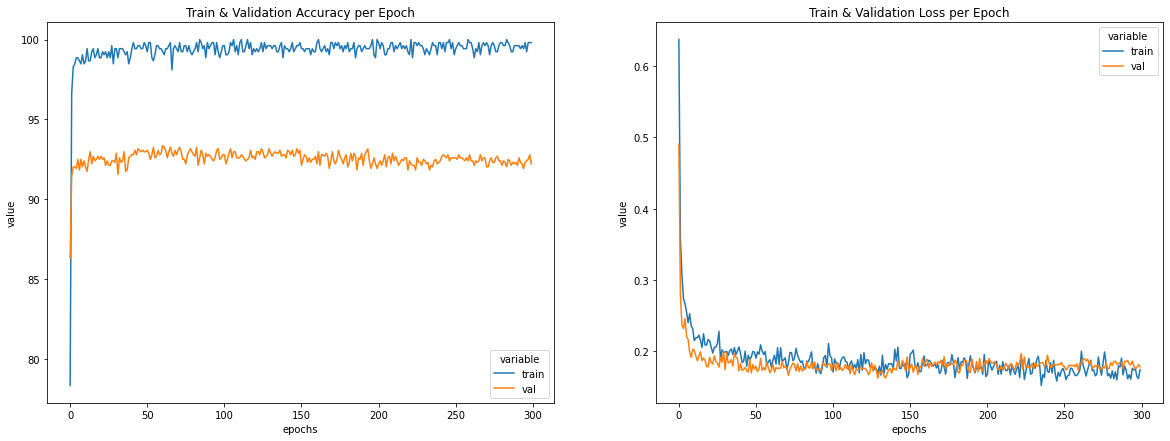

In [26]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(acc_dict).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_dict).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train & Validation Accuracy per Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train & Validation Loss per Epoch')

#### Response Features From Testing Predictor Features
Get the predicted classes (matchup results) from the testing data features.

In [27]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_DL:
        X_batch = X_batch.to('cuda:0')
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

#### Confusion Matrix

In [28]:
confusion_matrix(y_test, y_pred_list)

array([[335,  16,  28],
       [  5, 292,  32],
       [  3,  42, 563]], dtype=int64)

#### Results
The classification report below shows precision, recall, f1-score, and accuracy of the model with the testing dataset. It can be observed that the create ANN does a decent job at predicting matchup results.

In [29]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       379
           1       0.83      0.89      0.86       329
           2       0.90      0.93      0.91       608

    accuracy                           0.90      1316
   macro avg       0.90      0.90      0.90      1316
weighted avg       0.91      0.90      0.90      1316

